# Data Management Algorithm for Decision Making in Clash Royale
**Analyzing User Behavior in Clash Royale for Strategic Decision Making**

## Project Rationale
This project aims to leverage advanced data management algorithms to analyze user behavior in the popular mobile game Clash Royale.<br>
By utilizing datasets obtained from Kaggle, we will explore how different user behaviors impact game outcomes.<br>
The goal is to apply techniques learned in the course to understand which behaviors lead to winning, prolonged gameplay, and frequent app usage.

we will focuses on handling various steps in the data-driven decision-making process, including data integration, cleaning, and exploration.<br>
In this project we will address common data issues such as missing data, dirty or inconsistent data, and bias, ensuring trustworthy decision-making.

## Data Description
We will use the following datasets:
1. **BattlesStaging_01012021_WL_tagged.csv**: Contains data on games played on January 1, 2021. each row present 1 game between 2 players.
2. **Wincons.csv**: Contains information about impactful cards in the game.
3. **clash_royal_data.csv**: Contains specific card data, including ratings and usage statistics.

### Columns in BattlesStaging_01012021_WL_tagged.csv
- `Unnamed: 0`: Index
- `battleTime`: The time the battle started
- `arena.id`: The ID of the arena where the battle took place
- `gameMode.id`: The ID of the game mode
- `average.startingTrophies`: The average starting trophies of both players
- `winner.tag`: The tag of the winning player
- `winner.startingTrophies`: The starting trophies of the winning player
- `winner.trophyChange`: The change in trophies for the winning player
- `winner.crowns`: The number of crowns earned by the winning player
- `winner.kingTowerHitPoints`: The hit points of the winning player's king tower
- `winner.princessTowersHitPoints`: The hit points of the winning player's princess towers
- `winner.clan.tag`: The clan tag of the winning player
- `winner.clan.badgeId`: The clan badge ID of the winning player
- `loser.tag`: The tag of the losing player
- `loser.startingTrophies`: The starting trophies of the losing player
- `loser.trophyChange`: The change in trophies for the losing player
- `loser.crowns`: The number of crowns earned by the losing player
- `loser.kingTowerHitPoints`: The hit points of the losing player's king tower
- `loser.clan.tag`: The clan tag of the losing player
- `loser.clan.badgeId`: The clan badge ID of the losing player
- `loser.princessTowersHitPoints`: The hit points of the losing player's princess towers
- `tournamentTag`: The tag of the tournament (if applicable)
- `winner.card1.id` to `winner.card8.id`: The IDs of the winning player's cards
- `winner.card1.level` to `winner.card8.level`: The levels of the winning player's cards
- `winner.cards.list`: The list of cards of the winning player
- `winner.totalcard.level`: The total level of the cards of the winning player
- `winner.troop.count`: The count of troop cards of the winning player
- `winner.structure.count`: The count of structure cards of the winning player
- `winner.spell.count`: The count of spell cards of the winning player
- `winner.common.count`: The count of common cards of the winning player
- `winner.rare.count`: The count of rare cards of the winning player
- `winner.epic.count`: The count of epic cards of the winning player
- `winner.legendary.count`: The count of legendary cards of the winning player
- `winner.elixir.average`: The average elixir cost of the winning player's deck
- `loser.card1.id` to `loser.card8.id`: The IDs of the losing player's cards
- `loser.card1.level` to `loser.card8.level`: The levels of the losing player's cards
- `loser.cards.list`: The list of cards of the losing player
- `loser.totalcard.level`: The total level of the cards of the losing player
- `loser.troop.count`: The count of troop cards of the losing player
- `loser.structure.count`: The count of structure cards of the losing player
- `loser.spell.count`: The count of spell cards of the losing player
- `loser.common.count`: The count of common cards of the losing player
- `loser.rare.count`: The count of rare cards of the losing player
- `loser.epic.count`: The count of epic cards of the losing player
- `loser.legendary.count`: The count of legendary cards of the losing player
- `loser.elixir.average`: The average elixir cost of the losing player's deck

### Columns in Wincons.csv
- `id`: Index
- `card_id`: The ID of the card
- `card_name`: The name of the card

### Columns in clash_royal_data.csv
- `name`: The name of the card
- `Rating`: The rating of the card
- `Usage`: The usage percentage of the card
- `increase_in_usage`: The increase in usage percentage
- `Win`: The win percentage of the card
- `increase_in_win`: The increase in win percentage
- `CWR`: The card win rate


In [12]:
%reload_ext autoreload
%autoreload 2
# Import necessary libraries
import projcore as pc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.ensemble import IsolationForest
pd.set_option('display.max_columns', None)

## Data Integration, Cleaning, and Exploration
We will start by loading the datasets. We will then clean and explore the data to ensure it is ready for analysis.

In [ ]:
pc.download_kaggle_datasets()
battles_df = pd.read_csv('BattlesStaging_01012021_WL_tagged.csv')
card_list_df = pd.read_csv('CardMasterListSeason18_12082020.csv')
winning_card_list_df = pd.read_csv('Wincons.csv')
battles_df = pc.feature_preprocessing(battles_df, winning_card_list_df)

File BattlesStaging_01012021_WL_tagged/BattlesStaging_01012021_WL_tagged.csv already exists, skipping download
File CardMasterListSeason18_12082020.csv already exists, skipping download
File Wincons.csv already exists, skipping download
clash-royal-data.csv already exists, skipping download


## Feature Engineering
We will create new features to enhance our analysis. This includes calculating the elixir variability, trophy efficiency, and other metrics that can help us understand the factors influencing game outcomes.

In the next section, we create new features to enhance our analysis. These features include:

- `deck_elixir_variability`: Measures the variability in elixir cost between the winner and loser.
- `winner_trophy_eff` and `loser_trophy_eff`: Calculate the trophy efficiency for the winner and loser, respectively.
- `winner_card_level_std` and `loser_card_level_std`: Calculate the standard deviation of the levels of the winner's and loser's cards.
- `winner_spell_troop_ratio` and `loser_spell_troop_ratio`: Calculate the ratio of spell cards to troop cards for the winner and loser.
- `elixir_gap`: Measures the difference in average elixir cost between the winner and loser.
- `winner_rarity_diversity` and `loser_rarity_diversity`: Measure the diversity of card rarities in the winner's and loser's decks.
- `princess_tower_gap`: Measures the difference in princess tower hit points between the winner and loser.
- `win_streak_proxy`: A proxy for the winner's win streak.
- `winner_has_legendary` and `loser_has_legendary`: Indicate whether the winner or loser has legendary cards.
- `clan_advantage`: Indicates whether the winner has a clan advantage.
- `elixir_advantage`: Indicates whether the winner has an elixir advantage.
- `balanced_deck_winner` and `balanced_deck_loser`: Indicate whether the winner or loser has a balanced deck.
- `underleveled_winner` and `underleveled_loser`: Indicate whether the winner or loser is underleveled for the arena.
- `crown_dominance`: Indicates whether the winner has crown dominance.
- `winner_count`
- `loser_count`
- `total_games`
- `win_lose_ratio`
- `winner_winning_card_count`
- `loser_winning_card_count`
- `winner_card_set`
- `loser_card_set`
- `winner_deck_final_score`


These features help us understand the factors influencing game outcomes by providing more detailed metrics on player performance, deck composition, and game dynamics.

# YAGEL OR SALEH: GIVE GOOD NAME LIKE CASUAL INFERENCE OR SOMETHING LIKE THAT

## DAG Construction

in order to build our DAG, we will start with correlation : 

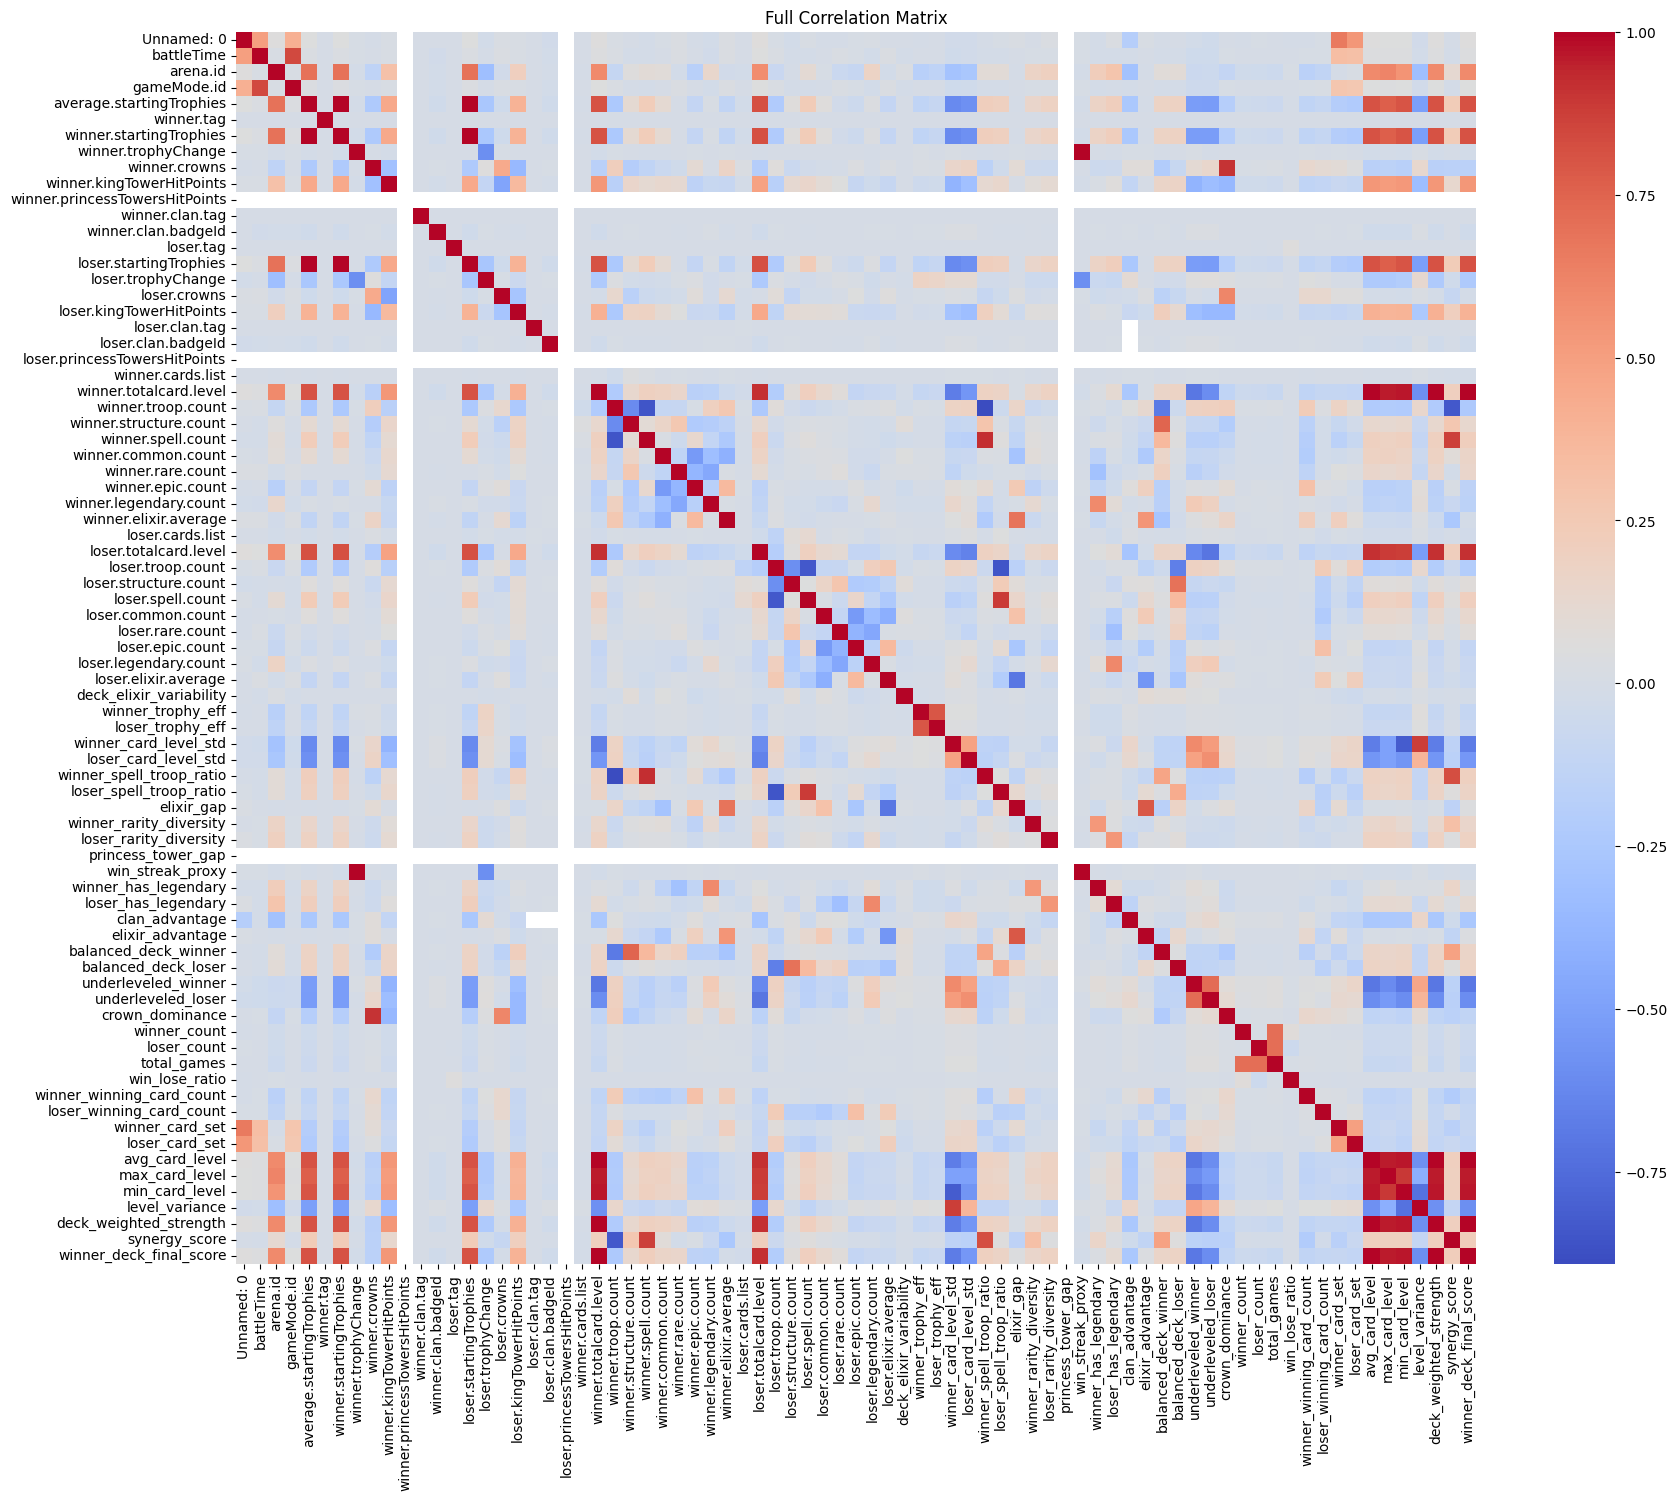

In [18]:
# Calculate the correlation matrix for the specified features
battles_df_for_dag = battles_df.copy()
battles_df_for_dag['loser_card_set'] = pd.factorize(battles_df_for_dag['loser_card_set'])[0]
battles_df_for_dag['winner_card_set'] = pd.factorize(battles_df_for_dag['winner_card_set'])[0]

correlation_matrix = battles_df_for_dag.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Full Correlation Matrix')
plt.show()

now we will look at the feature-pairs that have more than 0.5 corr

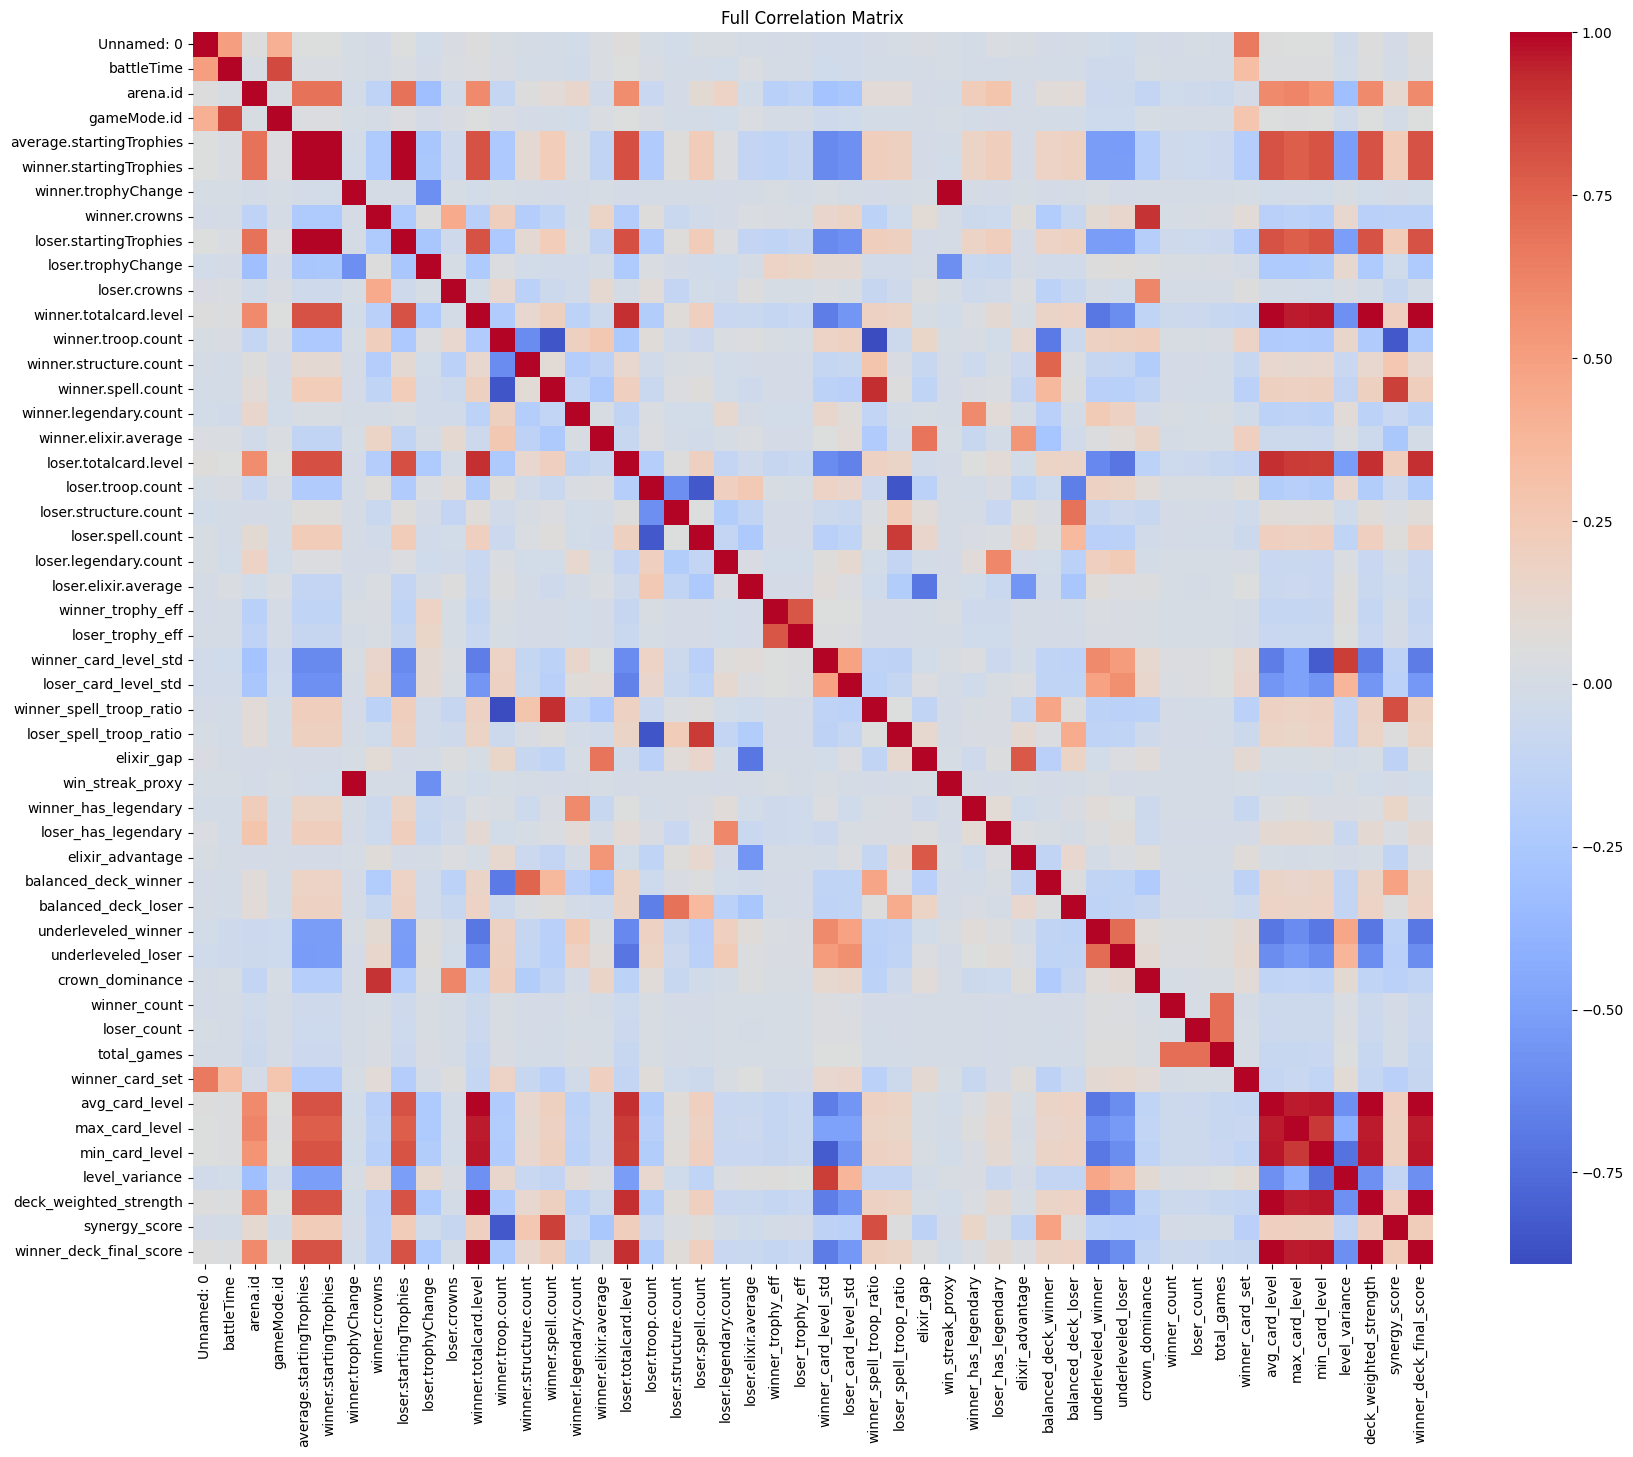

In [ ]:
potential_features = set()
# Iterate over the correlation matrix and print tuples with correlation >= 0.55
for i in range(len(correlation_matrix.columns)):
	for j in range(i+1, len(correlation_matrix.columns)):
		if abs(correlation_matrix.iloc[i, j]) > 0.55:
			potential_features.add(correlation_matrix.columns[i])
			potential_features.add(correlation_matrix.columns[j])

for feature in battles_df_for_dag.columns:
	if feature not in potential_features:
		battles_df_for_dag.drop(feature, axis=1, inplace=True)

correlation_matrix = battles_df_for_dag.corr()

plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Filtered Correlation Matrix')
plt.show()

## PCA and K-Means to find strong connections and special patterns

In this section, we will test our features in the cleaned and prepared dataset.
First, we denote our hureistic as 95% variance (explained in the article).
We run PCA once to find the best n for our problem: 
We want the cumulative variance to be at least 95%, but we want to reduce the dataset from 94 fetures as much as we can.
Then, we run PCA with our optimal value of n

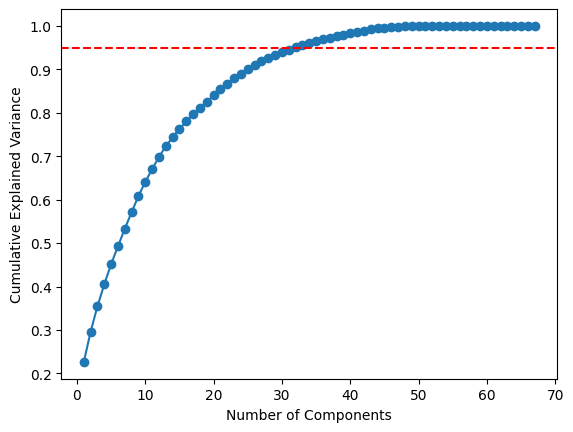

Best component: 32 with a cumulative_variance value of: 0.9511
Explained Variance Ratio: 0.9510955232621681


In [ ]:
filtered_df, n = pc.get_pca_optimal_components(battles_df)  
pca_n = PCA(n_components=n)
pca_for_df = pca_n.fit_transform(filtered_df)
df_pca = pd.DataFrame(pca_for_df, columns=[f"PC{i+1}" for i in range(n)])
print("Explained Variance Ratio:", pca_n.explained_variance_ratio_.sum())

We can see that n=32 is our optimal value for n components. Although this number reduces significantlly our dataset, it is still high enough to make it hard for interpretability so we run PCA with n=2 in order to gain some intuition of the data:

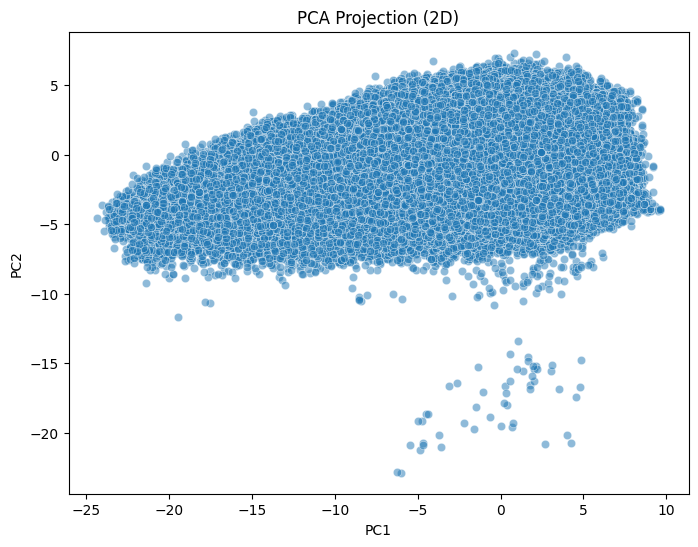

In [7]:
pca_2d = PCA(n_components=2).fit_transform(filtered_df)
df_pca_2d = pd.DataFrame(pca_2d, columns=["PC1", "PC2"])
plt.figure(figsize=(8,6))
sns.scatterplot(x="PC1", y="PC2", data=df_pca_2d, alpha=0.5)
plt.title("PCA Projection (2D)")
plt.show()

We can notice the dense region (main cluster), The majority of data points are packed in the upper region, indicating strong correlations within those principal components, but there's also some seperated points which my indicate subgroups or outliers. We will get back to our new dataset but for now we want to focus on the lower region of the plot, and understand if the corresponded points are outliers or unique subgroup/s. We use K_means to check the corresponded points, we checked clusters sized at 1..6 and 4 was the best option to understand the data:

/Users/roni/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


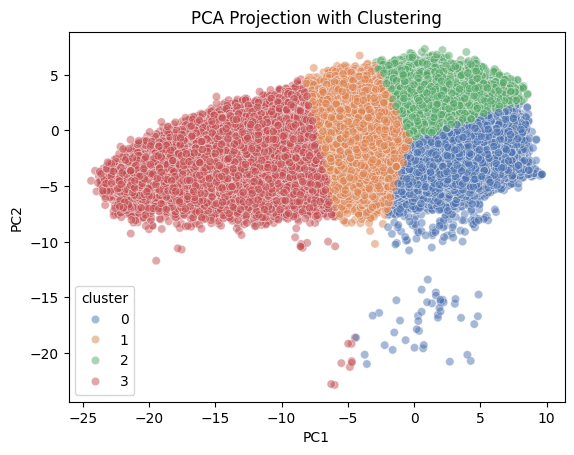

In [8]:
kmeans = KMeans(n_clusters=4)
df_pca_2d["cluster"] = kmeans.fit_predict(df_pca_2d[["PC1", "PC2"]])
sns.scatterplot(x="PC1", y="PC2", hue=df_pca_2d["cluster"], palette="deep", data=df_pca_2d, alpha=0.5)
plt.title("PCA Projection with K-means Clustering")
plt.show()

As seen, there is a cluster which contains most of the lower region, which may indicate information that we seek (in contrast to outliers). Back to our dataset with n_components = 32, we will check the properties of the dataset as the following:
1. Applying K-Means clustering on full PCA-Reduced Data
2. Detect outliers using isolation forest in full PCA space
3. Identify the cluster with the most outliers
4. Understand the features that most contribute to our subgroup
5. Extract outlier battles from the outlier cluster (Full Feature Data)
6. Examine the outliers, including probabilities and usage

Cluster 2 contains the most outliers.
Top Contributing Features for Outlier Cluster:
                      Feature  Importance
20          winner.epic.count    3.858731
58  winner_winning_card_count    3.820859
59   loser_winning_card_count    3.811899
18        winner.common.count    3.735715
29           loser.rare.count    3.717634
30           loser.epic.count    3.589630
19          winner.rare.count    3.521752
28         loser.common.count    3.493226
6   winner.kingTowerHitPoints    3.459401
22      winner.elixir.average    3.441306


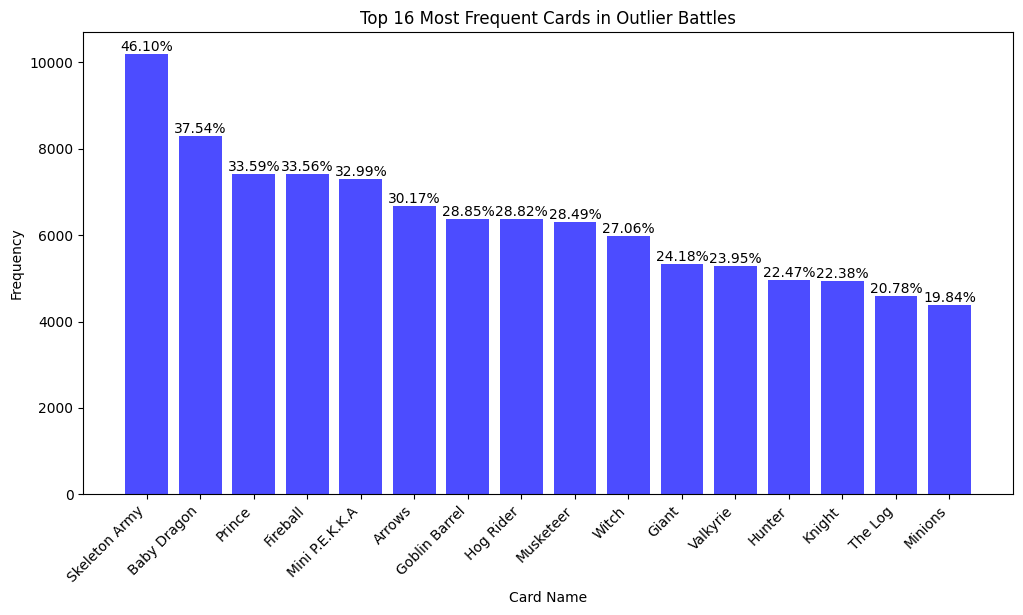

In [ ]:
# Step 1
kmeans = KMeans(n_clusters=4, random_state=42)
df_pca["cluster"] = kmeans.fit_predict(df_pca)

# Step 2
outlier_detector = IsolationForest(contamination=0.01, random_state=42)
df_pca["outlier"] = outlier_detector.fit_predict(df_pca.drop(columns=["cluster"]))

# Step 3
outlier_cluster = df_pca[df_pca["outlier"] == -1]["cluster"].value_counts().idxmax()
print(f"Cluster {outlier_cluster} contains the most outliers.")

# Step 4
numerical_dataset = pc.get_numerical_dataset(battles_df)
feature_contributions = np.abs(pca_n.components_).sum(axis=0)  # Sum of absolute contributions of all PCs
feature_importance = pd.DataFrame({"Feature": numerical_dataset.columns, "Importance": feature_contributions})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False).head(10)
print("Top Contributing Features for Outlier Cluster:")
print(feature_importance)

# Step 5
outlier_battle_indices = df_pca.index[(df_pca["outlier"] == -1) & (df_pca["cluster"] == outlier_cluster)]
outlier_battles = numerical_dataset.loc[outlier_battle_indices]
#outlier_battles.to_csv("battles_subset_outliers.csv", index=False)

# Step 6
outlier_battles_full = battles_df[battles_df["Unnamed: 0"].isin(outlier_battles["Unnamed: 0"])].copy()
card_histogram = Counter()
for cards in outlier_battles_full["winner_card_set"]:
    card_histogram.update(cards)
card_hist_df = pd.DataFrame.from_dict(card_histogram, orient='index', columns=['Count']).reset_index()
card_hist_df.columns = ['Card Index', 'Count']
card_hist_df = card_hist_df.merge(card_list_df, left_on='Card Index', right_on='team.card1.id', how='left')
card_hist_df['Card Name'] = card_hist_df['team.card1.name'].fillna('Unknown')
total_outlier_battles = len(outlier_battles_full)
card_hist_df['Probability'] = card_hist_df['Count'] / total_outlier_battles
# Selecting only the top 16 most frequent cards for visualization
card_hist_df = card_hist_df.sort_values(by='Count', ascending=False).head(16)
plt.figure(figsize=(12,6))
bars = plt.bar(card_hist_df['Card Name'], card_hist_df['Count'], color='blue', alpha=0.7)
plt.xlabel("Card Name")
plt.ylabel("Frequency")
plt.title("Top 16 Most Frequent Cards in Outlier Battles")
plt.xticks(rotation=45, ha='right')
for bar, prob in zip(bars, card_hist_df['Probability']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{prob:.2%}', ha='center', va='bottom', fontsize=10, color='black')
plt.show()

We can see that some cards which are used by the winner having a high probability of being chosen, let's check the full probability table of the top 16 used cards:

In [10]:
# Print DataFrame with probabilities
card_hist_df.drop(columns=['Card Index', 'team.card1.id', 'team.card1.name'], inplace=True)
print(card_hist_df)

    Count       Card Name  Probability
1    7019   Skeleton Army     0.506129
2    6269     Baby Dragon     0.452048
22   6005  Mini P.E.K.K.A     0.433011
27   5762          Prince     0.415489
19   5745        Fireball     0.414263
15   5480       Musketeer     0.395154
13   5438          Arrows     0.392126
16   5043       Hog Rider     0.363643
24   4913           Giant     0.354269
30   4548   Goblin Barrel     0.327949
28   4074           Witch     0.293770
17   4008          Hunter     0.289011
20   4002          Knight     0.288578
8    3764         Minions     0.271416
10   3400        Valkyrie     0.245169
32   2992         Archers     0.215748


Conclusion: we noticed some intresting facts: only 3 spells are used in the top 16 cards which construct the winner's deck, and 9 cards have a probability of more than 30% being choosed, while uniformaly speaking a card has a chance of ~5% probability of being choosed. We will prioritize the cards in the given table when checking for deck constructions.

### TODO: SALEH: ADD GRAPH AS SAID
### TODO: RONI: add explaination about most contributed features in PCA
### TODO: YAGEL AND RONI: add DAG per target features
### TODO: YAGEL: RUN UPDATED DAG
### TODO: YAGEL: UNDERSTAND WHAT TO DO WITH DAG
### TODO: YAGEL: maintain the feature names.
### DATELINE: 18/02 14:00